In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.optimize import curve_fit
from scipy.integrate import simps

import lightkurve as lk
import tessreduce as tr

import pickle

from datetime import datetime

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
coinciding_flares_df = pd.read_pickle('..\..\data\spt_tess_candidates_23_jun25.pkl')
print(coinciding_flares_df.columns)
coinciding_flares_df

Index(['index', 'peak_obsid', 'DR3_source_id', 'ra', 'dec', 'start_time',
       'end_time', 'mjd', 'sectors', 'TIC'],
      dtype='object')


,index,peak_obsid,DR3_source_id,ra,dec,start_time,end_time,mjd,sectors,TIC
0,12,205545046,6463748969563201408,319.964017,-53.449742,2023-07-07 23:50:47,2023-07-08 01:58:35,60132.993600,[67],TIC79394645
1,13,206191850,6388014157668558080,352.241030,-68.043088,2023-07-15 11:30:51,2023-07-15 13:38:39,60140.479757,[67],TIC229807000
2,14,206333946,6463546350186454144,320.183645,-54.633106,2023-07-17 02:59:07,2023-07-17 05:06:55,60142.124387,[67],TIC219317273
3,17,210122640,4904142818493218304,13.575856,-59.422393,2023-08-29 23:24:01,2023-08-30 01:31:49,60185.975012,[69],None


In [3]:
flare_star = coinciding_flares_df.iloc[2]

In [24]:
SPT_SS = pd.read_csv('../../data/SPT/cd558799_single_scan_lc_17july2023.csv')
SPT_SS = SPT_SS.sort_values(by= 'mjd')

(60141.2, 60141.7)

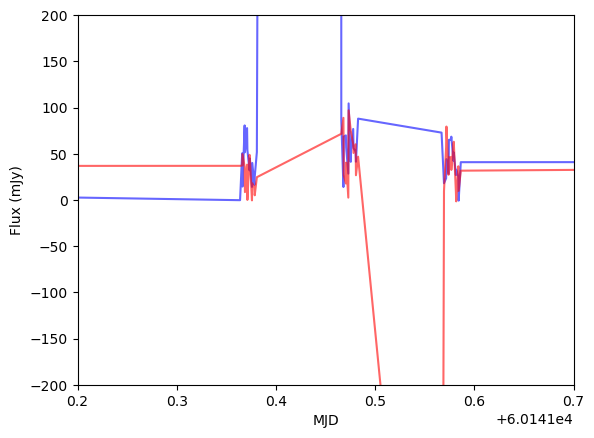

In [ ]:
d = (4.9967*u.mas).to(u.cm, equivalencies= u.parallax())
# d = 1/pi -> d_err = sigma_pi / pi^2 = sigma_pi/pi * d
d_err = (0.0147 * u.mas / (4.9967 * u.mas) * d)

'''
SPT (quiescent signal is ~0 mJy)
'''
# Grab SPT Single Scan Data
ss_times = SPT_SS['mjd']

ss_flux_90 = SPT_SS['flux_90']
fin_mask = np.isfinite(ss_flux_90)
ss_flux_90 = ss_flux_90[fin_mask]
ss_flux_err_90 = SPT_SS['flux_90_err'][fin_mask]
ss_times_90 = ss_times[fin_mask]

ss_flux_150 = SPT_SS['flux_150']
fin_mask = np.isfinite(ss_flux_150)
ss_flux_150 = ss_flux_150[fin_mask]
ss_flux_err_150 = SPT_SS['flux_150_err'][fin_mask]
ss_times_150 = ss_times[fin_mask]

# Plot SPT Lightcurves |  * 1e-26 * 22.7e9 * (4*np.pi*d**2)
plt.plot(ss_times_90, ss_flux_90, c= 'b', alpha= 0.6, label= 'SPT-3G 95 GHz')
plt.plot(ss_times_150, ss_flux_150, c= 'r', alpha= 0.6, label= 'SPT-3G 150 GHz')
# plt.errorbar(ss_times_90, ss_flux_90, yerr= np.abs(ss_flux_err_90), c= 'b', fmt='none', alpha= 0.6, capsize=5, label= 'SPT-3G 95 GHz')
# plt.errorbar(ss_times_150, ss_flux_150, yerr= np.abs(ss_flux_err_150), c= 'r', fmt='none', alpha= 0.6, capsize=5, label= 'SPT-3G 150 GHz')

plt.ylabel('Flux (mJy)')
plt.xlabel('MJD')
# plt.yscale('log')
plt.ylim(-200,200)
# plt.xlim(60141.2,60141.7)

In [94]:
# Prepare data for fitting
t_peak_90 = ss_times_90[np.argmax(ss_flux_90)]
ss_times_90_shifted = ss_times_90 - t_peak_90

t_peak_150 = ss_times_150[np.argmax(ss_flux_150)]
ss_times_150_shifted = ss_times_150 - t_peak_150

scaling_90 = np.max(ss_flux_90)  # Scale factor for normalization
ss_flux_90_rel = ss_flux_90 / scaling_90  # Normalize the flux for fitting
ss_flux_err_90_rel = ss_flux_err_90 / scaling_90

scaling_150 = np.max(ss_flux_150)  # Scale factor for normalization
ss_flux_150_rel = ss_flux_150 / scaling_150  # Normalize the flux for fitting
ss_flux_err_150_rel = ss_flux_err_150 / scaling_150

Text(0, 0.5, 'Relative Flux')

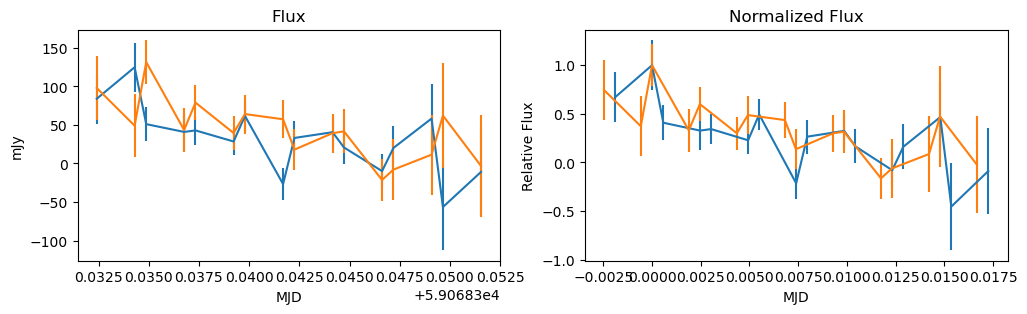

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.errorbar(ss_times_90, ss_flux_90, yerr= ss_flux_err_90)
ax1.errorbar(ss_times_150, ss_flux_150, yerr= ss_flux_err_150)
ax1.set_title('Flux')
ax1.set_xlabel('MJD')
ax1.set_ylabel('mJy')
ax2.errorbar(ss_times_90_shifted, ss_flux_90_rel, yerr= ss_flux_err_90_rel)
ax2.errorbar(ss_times_150_shifted, ss_flux_150_rel, yerr= ss_flux_err_150_rel)
ax2.set_title('Normalized Flux')
ax2.set_xlabel('MJD')
ax2.set_ylabel('Relative Flux')

In [96]:
def gauss(t, t_peak, amp, sigma):
    """Simple Gaussian function for flare fitting.
        Suggested by Howard and MacGregor (2023) for non_optical flares.
    """
    result = np.zeros_like(t)
    result = amp * np.exp(-0.5 * ((t - t_peak) / sigma) ** 2)
    return result

def double_gauss_shared_peak(tup, amp_90, sigma_90, amp_150, sigma_150, t_peak):
    t_90, t_150 = tup
    g90 = gauss(t_90, t_peak, amp_90, sigma_90)
    g150 = gauss(t_150, t_peak, amp_150, sigma_150)
    return np.concatenate([g90, g150])

In [97]:
!pip install numdifftools

In [98]:
from numdifftools import Jacobian  # or manually compute if model is simple

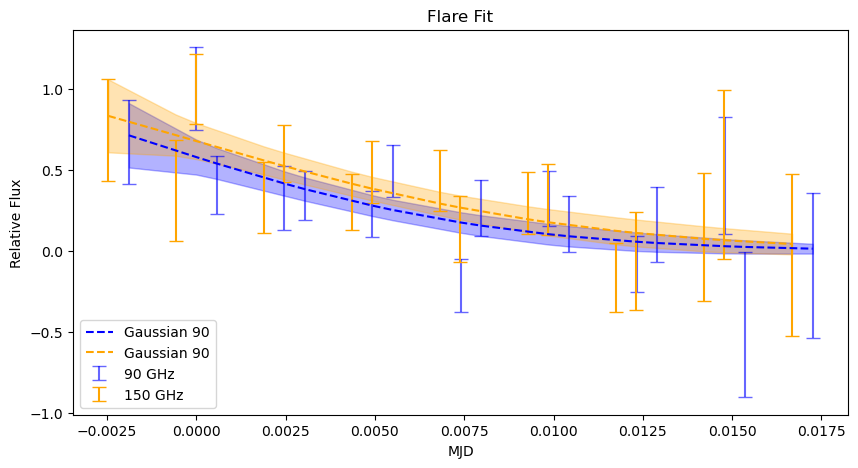

In [101]:
# Fit both bands with a shared peak time (t_peak)

# Initial guesses: amp_90, sigma_90, amp_150, sigma_150, shared t_peak
p0 = [np.max(ss_flux_90_rel), 0.005, np.max(ss_flux_150_rel), 0.005, 0.0]

# Concatenate data and errors for joint fit
tup = (ss_times_90_shifted, ss_times_150_shifted)
ydata = np.concatenate([ss_flux_90_rel, ss_flux_150_rel])
yerr = np.concatenate([np.abs(ss_flux_err_90_rel), np.abs(ss_flux_err_150_rel)])

popt, pcov = curve_fit(double_gauss_shared_peak, tup, ydata, sigma=yerr, p0=p0, maxfev=10000)
amp_90, sigma_90, amp_150, sigma_150, t_peak_shared = popt
sigma_90 = np.abs(sigma_90)
sigma_150 = np.abs(sigma_150)

model_90 = gauss(ss_times_90_shifted, t_peak_shared, amp_90, sigma_90)
model_150 = gauss(ss_times_150_shifted, t_peak_shared, amp_150, sigma_150)

def model_vec_90(params):
    amp_90, sigma_90, _, _, t_peak = params
    return gauss(ss_times_90_shifted, t_peak, amp_90, np.abs(sigma_90))

def model_vec_150(params):
    _, _, amp_150, sigma_150, t_peak = params
    return gauss(ss_times_150_shifted, t_peak, amp_150, np.abs(sigma_150))

# Compute Jacobians
J_90 = Jacobian(model_vec_90)(popt)  # Shape: [len(times_90), 5]
J_150 = Jacobian(model_vec_150)(popt)  # Shape: [len(times_150), 5]

# Error propagation: σ_fit² = J @ pcov @ J.T → row-wise sum
sigma_fit_90 = np.sqrt(np.sum(J_90 @ pcov * J_90, axis=1))
sigma_fit_150 = np.sqrt(np.sum(J_150 @ pcov * J_150, axis=1))

plt.figure(figsize=(10, 5))
plt.errorbar(ss_times_90_shifted, ss_flux_90_rel, yerr= np.abs(ss_flux_err_90) / scaling_90, label='90 GHz', c= 'blue', fmt='none', alpha= 0.6, capsize=5,)
plt.errorbar(ss_times_150_shifted, ss_flux_150_rel, yerr= np.abs(ss_flux_err_150) / scaling_150, label='150 GHz', c= 'orange', fmt='none', capsize=5,)
plt.plot(ss_times_90_shifted, model_90, label='Gaussian 90', linestyle= '--', color='blue')
plt.plot(ss_times_150_shifted, model_150, label='Gaussian 90', linestyle= '--', color='orange')
plt.fill_between(ss_times_90_shifted, model_90 - sigma_fit_90, model_90 + sigma_fit_90, alpha=0.3, color='blue')
plt.fill_between(ss_times_150_shifted, model_150 - sigma_fit_150, model_150 + sigma_fit_150, alpha=0.3, color='orange')
plt.xlabel('MJD')
plt.ylabel('Relative Flux')
plt.legend()
plt.title('Flare Fit')
plt.show()

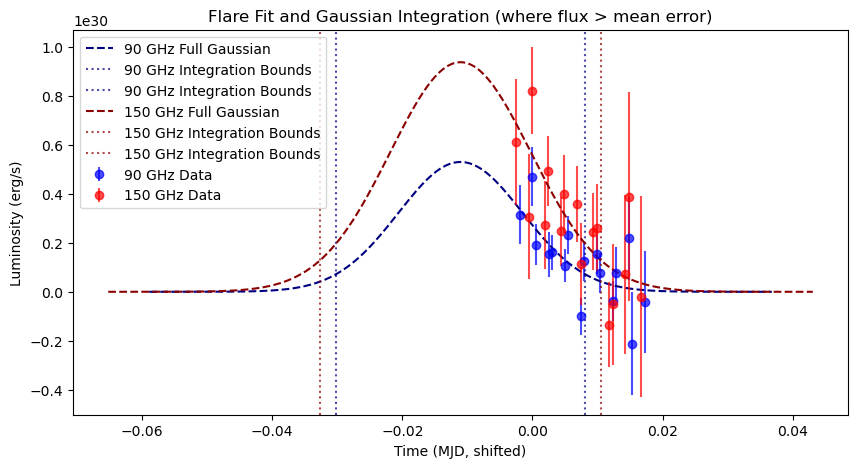

Integrated energy (90 GHz, flux > mean error): 1.049e+33 erg
Integrated energy (150 GHz, flux > mean error): 2.099e+33 erg
Flare Integral Duration (90 GHz): 3297.77 s
Flare Integral Duration (150 GHz): 3731.58 s


In [102]:
# Calculate mean errors for each band
mean_err_90 = np.mean(np.abs(ss_flux_err_90))
mean_err_150 = np.mean(np.abs(ss_flux_err_150))

# 90 GHz
noise_90 = mean_err_90 / scaling_90
left_bound_90 = t_peak_shared - 2 * sigma_90
right_bound_90 = t_peak_shared + 2 * sigma_90

# Find where the Gaussian drops below the noise level
while gauss(left_bound_90, t_peak_shared, amp_90, sigma_90) > noise_90:
    left_bound_90 -= sigma_90 / 100
while gauss(right_bound_90, t_peak_shared, amp_90, sigma_90) > noise_90:
    right_bound_90 += sigma_90 / 100

full_times_90 = np.linspace(t_peak_shared - 5 * sigma_90, t_peak_shared + 5 * sigma_90, 500)
full_model_90 = gauss(full_times_90, t_peak_shared, amp_90, sigma_90) * scaling_90 * u.mJy
int_mask_90 = (full_times_90 > left_bound_90) & (full_times_90 < right_bound_90)

full_times_90 = full_times_90 * u.day
fluence_90_full = np.trapz(y= full_model_90[int_mask_90], x= full_times_90[int_mask_90].to(u.s))  # Convert to seconds for integration
energy_90_full = (fluence_90_full * (22.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg)

# def model_vec_90_full(params):
#     amp_90, sigma_90, _, _, t_peak = params
#     return gauss(full_times_90.value, t_peak, amp_90, np.abs(sigma_90))
# J_90 = Jacobian(model_vec_90_full)(popt)  # Shape: [len(times_90), 5]
# sigma_fit_90_full = np.sqrt(np.sum(J_90 @ pcov * J_90, axis=1)) * scaling_90 * u.mJy
# sigma_fluence_90 = np.trapz(y= sigma_fit_90_full[int_mask_90], x= full_times_90[int_mask_90].to(u.s))
# sigma_E_90 = np.sqrt((sigma_fluence_90 * (22.7e9*u.Hz) * 4 * np.pi * d**2)**2
#                   + (d_err * fluence_90_full * (22.7e9*u.Hz) * 8 * np.pi * d)**2).to(u.erg)

# 150 GHz
noise_150 = mean_err_150 / scaling_150
left_bound_150 = t_peak_shared - 2 * sigma_150
right_bound_150 = t_peak_shared + 2 * sigma_150

# Find where the Gaussian drops below the noise level
while gauss(left_bound_150, t_peak_shared, amp_150, sigma_150) > noise_150:
    left_bound_150 -= sigma_150 / 100
while gauss(right_bound_150, t_peak_shared, amp_150, sigma_150) > noise_150:
    right_bound_150 += sigma_150 / 100

full_times_150 = np.linspace(t_peak_shared - 5 * sigma_150, t_peak_shared + 5 * sigma_150, 500)
full_model_150 = gauss(full_times_150, t_peak_shared, amp_150, sigma_150) * scaling_150 * u.mJy
int_mask_150 = (full_times_150 > left_bound_150) & (full_times_150 < right_bound_150)

full_times_150 = full_times_150 * u.day
fluence_150_full = np.trapz(y= full_model_150[int_mask_150], x= full_times_150[int_mask_150].to(u.s))  # Convert to seconds for integration
energy_150_full = (fluence_150_full * (37.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg)

# def model_vec_150_full(params):
#     _, _, amp_150, sigma_150, t_peak = params
#     return gauss(full_times_150.value, t_peak, amp_150, np.abs(sigma_150))
# J_150 = Jacobian(model_vec_150_full)(popt)  # Shape: [len(times_150), 5]
# sigma_fit_150_full = np.sqrt(np.sum(J_150 @ pcov * J_150, axis=1)) * scaling_150 * u.mJy
# sigma_fluence_150 = np.trapz(y= sigma_fit_150_full[int_mask_150], x= full_times_150[int_mask_150].to(u.s))
# sigma_E_150 = np.sqrt((sigma_fluence_150 * scaling_150 * (37.7e9*u.Hz) * 4 * np.pi * d**2)**2
#                   + (d_err * fluence_150_full * (37.7e9*u.Hz) * 8 * np.pi * d)**2).to(u.erg)

plt.figure(figsize=(10, 5))
plt.errorbar(ss_times_90_shifted, ss_flux_90 * 1e-26 * 22.7e9 * (4*np.pi*d**2), yerr=np.abs(ss_flux_err_90) * 1e-26 * 22.7e9 * (4*np.pi*d**2), fmt='o', label='90 GHz Data', color='blue', alpha=0.7)
plt.plot(full_times_90, (full_model_90 * (22.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), '--', color='navy', label='90 GHz Full Gaussian')
# plt.fill_between(full_times_90[int_mask], 0, full_model_90[int_mask], color='navy', alpha=0.1, label='90 GHz Integrated Area (Full)')
plt.axvline(left_bound_90, color='navy', linestyle=':', alpha=0.7, label='90 GHz Integration Bounds')
plt.axvline(right_bound_90, color='navy', linestyle=':', alpha=0.7, label='90 GHz Integration Bounds')

plt.errorbar(ss_times_150_shifted, ss_flux_150 * 1e-26 * 37.7e9 * (4*np.pi*d**2), yerr=np.abs(ss_flux_err_150) * 1e-26 * 37.7e9 * (4*np.pi*d**2), fmt='o', label='150 GHz Data', color='red', alpha=0.7)
plt.plot(full_times_150, (full_model_150 * (37.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), '--', color='darkred', label='150 GHz Full Gaussian')
# plt.fill_between(full_times_150[int_mask], 0, full_model_150[int_mask], color='darkred', alpha=0.1, label='150 GHz Integrated Area (Full)')
plt.axvline(left_bound_150, color='darkred', linestyle=':', alpha=0.7, label='150 GHz Integration Bounds')
plt.axvline(right_bound_150, color='darkred', linestyle=':', alpha=0.7, label='150 GHz Integration Bounds')

plt.xlabel('Time (MJD, shifted)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Flare Fit and Gaussian Integration (where flux > mean error)')
plt.legend()
plt.show()

print(f"Integrated energy (90 GHz, flux > mean error): {energy_90_full:.3e}") # ± {sigma_E_90:.3e}
print(f"Integrated energy (150 GHz, flux > mean error): {energy_150_full:.3e}") # ± {sigma_E_150:.3e} 
print(f"Flare Integral Duration (90 GHz): {(full_times_90[int_mask_90][-1] - full_times_90[int_mask_90][0]).to(u.s):.2f}")
print(f"Flare Integral Duration (150 GHz): {(full_times_150[int_mask_150][-1] - full_times_150[int_mask_150][0]).to(u.s):.2f}")